# Desarrollo del proyecto

## Imports

In [208]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
import statistics
import sklearn as sk
import json
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier, Ridge, LogisticRegression
from sklearn import tree
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import loguniform

## Creación del Data Frame

El primer paso es cargar los datasets y juntarlos en único dataframe.

Además se almacena en una nueva columna el dataset del que provienen, ya que indica el rango del jugador, lo que puede ser un dato útil.

In [380]:
def load_data():
    #Cargamos los CSV
    df1 = pd.read_csv('./TFT_Challenger_MatchData.csv')
    df2 = pd.read_csv('./TFT_GrandMaster_MatchData.csv')
    df3 = pd.read_csv('./TFT_Master_MatchData.csv')
    df4 = pd.read_csv('./TFT_Diamond_MatchData.csv')
    df5 = pd.read_csv('./TFT_Platinum_MatchData.csv')

    #Guardamos el DF del que proviene en una variable porque contiene información del rango de los jugadores
    RANK_COLUMN_NAME = 'rank'
    df1[RANK_COLUMN_NAME]=1 #Challenger
    df2[RANK_COLUMN_NAME]=2 #GrandMaster
    df3[RANK_COLUMN_NAME]=3 #Master
    df4[RANK_COLUMN_NAME]=4 #Diamond
    df5[RANK_COLUMN_NAME]=5 #Master

    #Mergeamos los DF en uno solo
    df = pd.concat([df1, df2, df3, df4, df5]).reset_index(drop=True)

    return df

In [381]:
#Inicializamos el DF
data_frame = load_data()

Se eliminan las columnas que no se van a utilizar y se cambia el nombre para ser más claro.

In [382]:
def format_data(df):
    #Formateo del DF
    df.drop(columns=['gameDuration', 'ingameDuration'], inplace=True)
    df.rename(columns={'Ranked':'position'}, inplace=True)

In [383]:
#Borramos las columnas inútiles
format_data(data_frame)

In [384]:
data_frame

,gameId,level,lastRound,position,combination,champion,rank
0,KR_4247538593,8,35,1,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': {'items': [27], 'star': 3}, 'Sona...",1
1,KR_4247538593,9,35,2,"{'Blaster': 2, 'Mercenary': 1, 'Rebel': 6, 'Se...","{'Malphite': {'items': [7], 'star': 2}, 'Yasuo...",1
2,KR_4247538593,8,34,3,"{'Cybernetic': 1, 'DarkStar': 3, 'Demolitionis...","{'KaiSa': {'items': [99, 2, 23], 'star': 2}, '...",1
3,KR_4247538593,8,33,4,"{'Blaster': 1, 'Cybernetic': 1, 'DarkStar': 1,...","{'KaiSa': {'items': [44, 37], 'star': 2}, 'Ann...",1
4,KR_4247538593,9,33,5,"{'Blaster': 2, 'Demolitionist': 2, 'Mercenary'...","{'Ziggs': {'items': [], 'star': 1}, 'Yasuo': {...",1
...,...,...,...,...,...,...,...
399993,KR_4296831363,7,34,4,"{'Chrono': 2, 'Cybernetic': 1, 'Protector': 2,...","{'TwistedFate': {'items': [58], 'star': 2}, 'X...",5
399994,KR_4296831363,8,33,5,"{'Chrono': 2, 'Cybernetic': 1, 'Infiltrator': ...","{'Xayah': {'items': [5], 'star': 2}, 'Yasuo': ...",5
399995,KR_4296831363,8,38,2,"{'Blaster': 1, 'DarkStar': 1, 'MechPilot': 1, ...","{'Poppy': {'items': [], 'star': 2}, 'Zoe': {'i...",5
399996,KR_4296831363,8,35,3,"{'Blaster': 2, 'Chrono': 1, 'Demolitionist': 1...","{'Ziggs': {'items': [44, 48], 'star': 3}, 'Mal...",5


### Limpieza de datos

Se eliminan las partidas incompletas porque pueden dar luegar a datos erróneos.

In [385]:
#Se borran todas las partidas que no tengan datos de 8 jugadores
def validate_games(df):
    df_grouped = df['gameId'].value_counts()
    incomplete_games = df_grouped[df_grouped != 8]
    print(f'Hay {len(incomplete_games)} partidas incompletas')
    df.drop(index=df[df['gameId'].isin(incomplete_games.keys())].index, inplace=True)

In [386]:
validate_games(data_frame)

Hay 21 partidas incompletas


Se eliminan también las partidas con datos de posición que sean erróneos. Las posiciones deben estar entre 1 y 8.

In [387]:
def validate_position(df):
    #Comprobamos que las posiciones tengan valores correctos (enteros entre 1 y 8)
    position_condition = df[(df['position'] < 1) | (df['position'] > 8)]
    invalid_position = len(position_condition)
    invalid_games = position_condition['gameId'].unique()
    print(f'Hay {invalid_position} valores incorrectos de posición en {len(invalid_games)} partidas.')
    #Comprobamos que sólo puede haber ints
    print(f"Type: {df['position'].dtype}")
    #Borramos todos los datos de partidas con posición incorrecta (112 en vez de 92)
    df.drop(index=df[df['gameId'].isin(invalid_games)].index, inplace=True)

In [388]:
#Borramos los valores no válidos de posición
validate_position(data_frame)

Hay 92 valores incorrectos de posición en 14 partidas.
Type: int64


Además se eliminan todas las partidas que tengan algún dato de nivel mayor que 9 (es imposible) o menor que 5, lo que se consideraria una muestra anómala (jugadores AFK o que se rinden)

In [389]:
#Para comprobar los valores de la columna level aplicamos el mismo método que en position
#Valores correctos son enteros entre 5 y 9
def validate_level(df):
    level_condition = df[(df['level'] < 5) | (df['level'] > 9)]
    invalid_level = len(level_condition)
    invalid_games = level_condition['gameId'].unique()
    print(f'Hay {invalid_level} valores incorrectos de level en {len(invalid_games)} partidas.')
    #Comprobamos que sólo puede haber ints
    print(f"Type: {df['level'].dtype}")
    df.drop(index=df[df['gameId'].isin(invalid_games)].index, inplace=True)

In [390]:
#Borramos los valores no válidos de level
validate_level(data_frame)
data_frame.reset_index(inplace=True)
data_frame.drop(columns=['index'], inplace=True)

Hay 307 valores incorrectos de level en 211 partidas.
Type: int64


Se representa la gráfica con la cantidad de datos para cada posición para comprobar que el dataset está equilibrado.

Por la naturaleza del dataset, donde cada partida tiene 8 jugadores y cada uno toma una posición distinta, se obtiene el resultado esperado.

<BarContainer object of 8 artists>

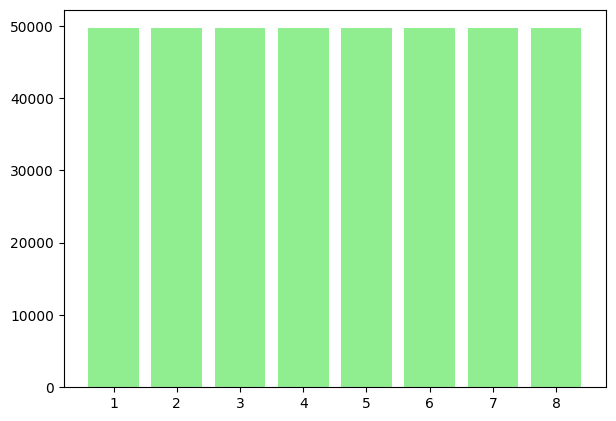

In [391]:
#Número de veces que se repite cada valor de posición
plt.bar(data_frame['position'].unique(),data_frame['position'].value_counts(), color = 'lightgreen')

Se hace también una comprobación de que todas las columnas contienen el mismo número de valores.

Esto garantiza que tienen algún tipo de dato pero no evita cosas como arrays vacíos.

In [392]:
#Comprobamos que el número de valores es el mismo para todas las columnas
print(f'Número de valores por columna:\n{data_frame.count()}')

Número de valores por columna:
gameId         397880
level          397880
lastRound      397880
position       397880
combination    397880
champion       397880
rank           397880
dtype: int64


## Preproceamiento

### Procesamiento de campeones

In [393]:
#Generamos la lista de los nombres de los campeones
with open('./champions.json') as f:
    champions_json = json.load(f)
champ_names = []
for champ in champions_json:
    champ_names.append(champ['name'])

Ejecutar después de procesamiento de campeones

Probamos a calcular nuevas columnas que tengan nuevos datos que puedan ayudar al algoritmo.

In [ ]:
#Preprocesamiento de campeones
champs_list = []
for champs_df in data_frame['champion']:
    champs_df = champs_df.replace("'",'"') 
    champs_df = json.loads(champs_df)
    new_row = { i : 0 for i in champ_names }
    for key in champs_df:
        champ_df=champs_df[key]
        for champ_json in champions_json:
            if key == champ_json['name']:
                champ_name = champ_json['name']
                new_row[champ_name] = champ_df['star']
    champs_list.append(new_row)

In [ ]:
new_champs_df = pd.DataFrame(champs_list, columns=champ_names)
data_frame = data_frame.join(new_champs_df).reset_index(drop=True)
data_frame

,gameId,level,lastRound,position,combination,champion,rank,Ahri,Annie,Ashe,...,TwistedFate,VelKoz,Vi,WuKong,Xayah,Xerath,XinZhao,Yasuo,Ziggs,Zoe
0,KR_4247538593,8,35,1,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': {'items': [27], 'star': 3}, 'Sona...",1,0,0,0,...,0,0,0,0,0,0,3,0,0,0
1,KR_4247538593,9,35,2,"{'Blaster': 2, 'Mercenary': 1, 'Rebel': 6, 'Se...","{'Malphite': {'items': [7], 'star': 2}, 'Yasuo...",1,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2,KR_4247538593,8,34,3,"{'Cybernetic': 1, 'DarkStar': 3, 'Demolitionis...","{'KaiSa': {'items': [99, 2, 23], 'star': 2}, '...",1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,KR_4247538593,8,33,4,"{'Blaster': 1, 'Cybernetic': 1, 'DarkStar': 1,...","{'KaiSa': {'items': [44, 37], 'star': 2}, 'Ann...",1,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,KR_4247538593,9,33,5,"{'Blaster': 2, 'Demolitionist': 2, 'Mercenary'...","{'Ziggs': {'items': [], 'star': 1}, 'Yasuo': {...",1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397875,KR_4296831363,7,34,4,"{'Chrono': 2, 'Cybernetic': 1, 'Protector': 2,...","{'TwistedFate': {'items': [58], 'star': 2}, 'X...",5,0,0,0,...,2,1,2,0,2,0,2,0,0,0
397876,KR_4296831363,8,33,5,"{'Chrono': 2, 'Cybernetic': 1, 'Infiltrator': ...","{'Xayah': {'items': [5], 'star': 2}, 'Yasuo': ...",5,0,0,0,...,0,0,0,2,2,0,0,1,0,0
397877,KR_4296831363,8,38,2,"{'Blaster': 1, 'DarkStar': 1, 'MechPilot': 1, ...","{'Poppy': {'items': [], 'star': 2}, 'Zoe': {'i...",5,3,3,0,...,0,2,0,0,0,0,0,0,0,2
397878,KR_4296831363,8,35,3,"{'Blaster': 2, 'Chrono': 1, 'Demolitionist': 1...","{'Ziggs': {'items': [44, 48], 'star': 3}, 'Mal...",5,0,0,0,...,0,0,0,0,0,0,0,3,3,0


### Procesamiento de traits

Se almacena en cada columna de sinergia el valor activo de esta. Esto se consigue comparando el valor del dataset con los mínimos y máximos del json de traits.

In [ ]:
#Procesamos los datos del json de traits
#Cargamos los datos del json a un objeto
with open('./traits.json') as f:
    traits_json = json.load(f)

Se obtienen los nombres de las sinergias del json

In [227]:
#Genera la lista de los nombre de los traits
trait_names = []
for trait in traits_json:
    trait_names.append(trait['name'])

In [228]:
#Crea una lista con los valores de los traits de todo el df original a partir de la columna combination
traits_list = []
#sum_list = []
#Recorremos los valores de combination de cada fila
for traits_df in data_frame['combination']:
    #Cargamos los valores en un objeto (hace falta modificar las comillas por temas de sintaxis con la libreria)
    traits_df = traits_df.replace("'",'"') 
    traits_df = json.loads(traits_df)
    #Generamos el objeto que se añadirá al df para cada fila (se inicializa con todos los valores a 0
    new_row = { i : 0 for i in trait_names }
    #Recorremos cada uno de los valores de sinergia
    #sum_traits = 0
    for trait_df in traits_df:
        for trait_json in traits_json:
            #Comprobamos que el trait almacenado en el df se corresponde con alguno de los procesados en el json de traits
            if trait_df == trait_json['key']:
                trait_name = trait_json['name']
                value_df = traits_df[trait_df]
                tier = 'None'
                #Iteramos sobre los posibles tiers del trait hasta que encontramos el correcto
                for trait_tier in trait_json['sets']:
                    if value_df>=trait_tier['min']:
                        tier = trait_tier['style']
                    else:
                        break
                #Añadimos el valor al DF en función del tier de sinergia obtenido
                if tier=='bronze':
                    new_row[trait_name] = 1
                elif tier=='silver':
                    new_row[trait_name] = 2
                elif tier=='gold':
                    new_row[trait_name] = 3
                elif tier=='chromatic':
                    new_row[trait_name] = 4
                #sum_traits += new_row[trait_name]
    #sum_list.append(sum_traits)
    #Añadimos la nueva fila generada al nuevo df
    traits_list.append(new_row)

Se eliminan las dos sinergias únicas para evitar información innecesaria.

In [ ]:
#Inicializamos un nuevo df vacío con las nuevas columnas de traits
new_trait_df = pd.DataFrame(traits_list, columns=trait_names)
new_trait_df.drop(columns=['Mercenary','Starship'], inplace=True)
data_frame = data_frame.join(new_trait_df).reset_index(drop=True)
data_frame

### Comprobación de traits

Se va a comprobar si la distribución de sinergias varía entre posiciones.

Primero se representan las sinergias para la posición 1

In [420]:
data_frame_traits = data_frame[data_frame['position']==1]
data_frame_traits = data_frame_traits.drop(columns=champ_names)
data_frame_traits.drop(columns=['gameId','level','lastRound','position','champion','rank','combination'], inplace=True)
data_frame_traits

,Blademaster,Blaster,Brawler,Celestial,Chrono,Cybernetic,Dark Star,Demolitionist,Infiltrator,Mana-Reaver,...,Mystic,Protector,Rebel,Sniper,Sorcerer,Space Pirate,Star Guardian,Valkyrie,Vanguard,Void
0,0,0,0,1,0,0,0,0,0,0,...,3,3,0,0,0,0,0,0,0,0
8,1,1,0,1,0,0,0,3,0,0,...,1,0,3,0,0,0,0,0,0,0
16,0,1,0,0,0,0,0,3,0,0,...,0,0,3,0,0,0,0,0,0,0
24,0,3,3,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
32,0,0,0,1,0,0,0,0,0,0,...,3,3,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397843,0,3,1,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397848,0,3,3,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397861,0,0,0,2,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
397871,0,0,0,2,0,0,0,0,1,1,...,0,1,0,3,0,0,0,0,0,0


In [421]:
trait_count=[]
for col in data_frame_traits.columns:
    trait_count.append({'trait':col,'1':len(data_frame_traits[data_frame_traits[col]==1]),'2':len(data_frame_traits[data_frame_traits[col]==2]),
                        '3':len(data_frame_traits[data_frame_traits[col]==3]),'4':len(data_frame_traits[data_frame_traits[col]==4])})

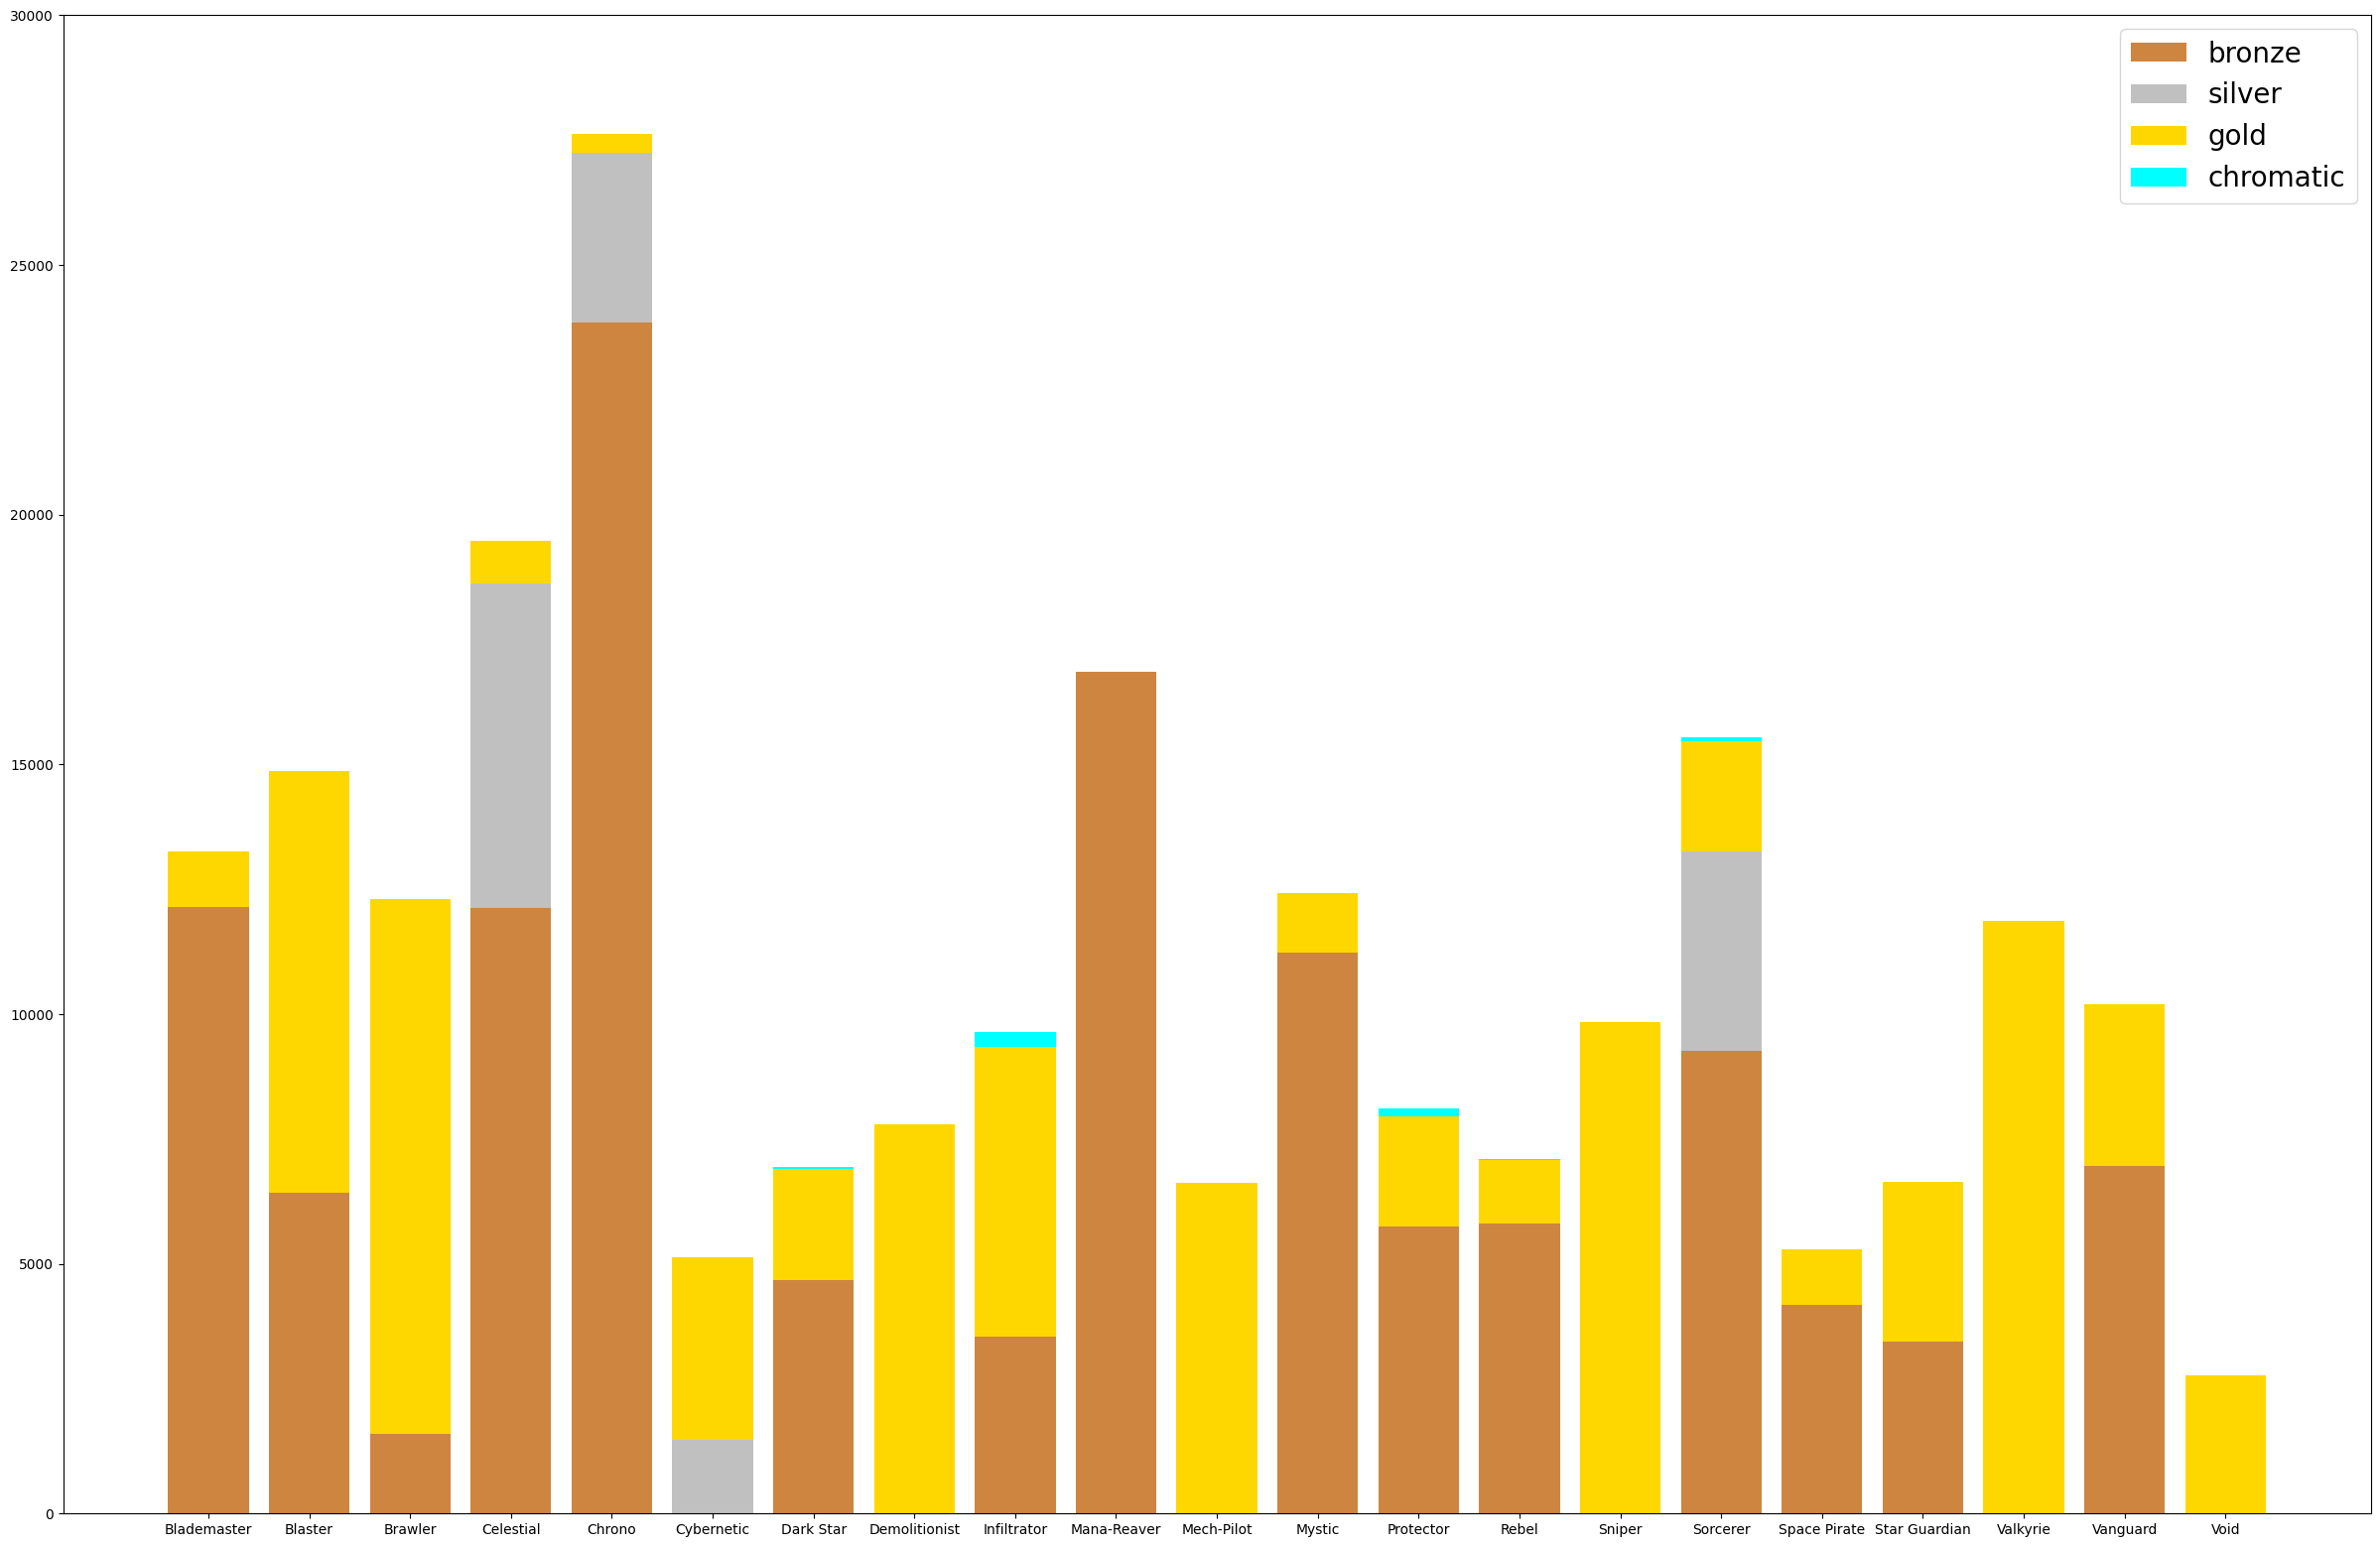

In [422]:
trait1 = []
trait2 = []
trait3 = []
trait4 = []
plt.figure(figsize = (30,20))
for trait in trait_count:
    trait1.append(trait['1'])
    trait2.append(trait['2'])
    trait3.append(trait['3'])
    trait4.append(trait['4'])
y1=np.array(trait1)
y2=np.array(trait2)
y3=np.array(trait3)
y4=np.array(trait4)
plt.bar(data_frame_traits.columns, y1, color='peru', label='bronze')
plt.bar(data_frame_traits.columns, y2, bottom=y1, color="silver", label='silver')
plt.bar(data_frame_traits.columns, y3, bottom=y1+y2, color='gold', label='gold')
plt.bar(data_frame_traits.columns, y4, bottom=y1+y2+y3, color='cyan', label='chromatic')
plt.ylim(0,30000)
plt.legend(prop={'size': 20})
plt.show()

Después se representan las sinergias para la posición 8, manteniendo el mismo valor máximo

In [423]:
data_frame_traits = data_frame[data_frame['position']==8]
data_frame_traits = data_frame_traits.drop(columns=champ_names)
data_frame_traits.drop(columns=['gameId','level','lastRound','position','champion','rank','combination'], inplace=True)
data_frame_traits

,Blademaster,Blaster,Brawler,Celestial,Chrono,Cybernetic,Dark Star,Demolitionist,Infiltrator,Mana-Reaver,...,Mystic,Protector,Rebel,Sniper,Sorcerer,Space Pirate,Star Guardian,Valkyrie,Vanguard,Void
7,0,3,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,1,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0
23,0,1,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
31,0,0,0,1,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
39,1,1,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397845,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
397852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,3,0,0,0
397856,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397864,0,0,0,1,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0


In [424]:
trait_count=[]
for col in data_frame_traits.columns:
    trait_count.append({'trait':col,'1':len(data_frame_traits[data_frame_traits[col]==1]),'2':len(data_frame_traits[data_frame_traits[col]==2]),
                        '3':len(data_frame_traits[data_frame_traits[col]==3]),'4':len(data_frame_traits[data_frame_traits[col]==4])})

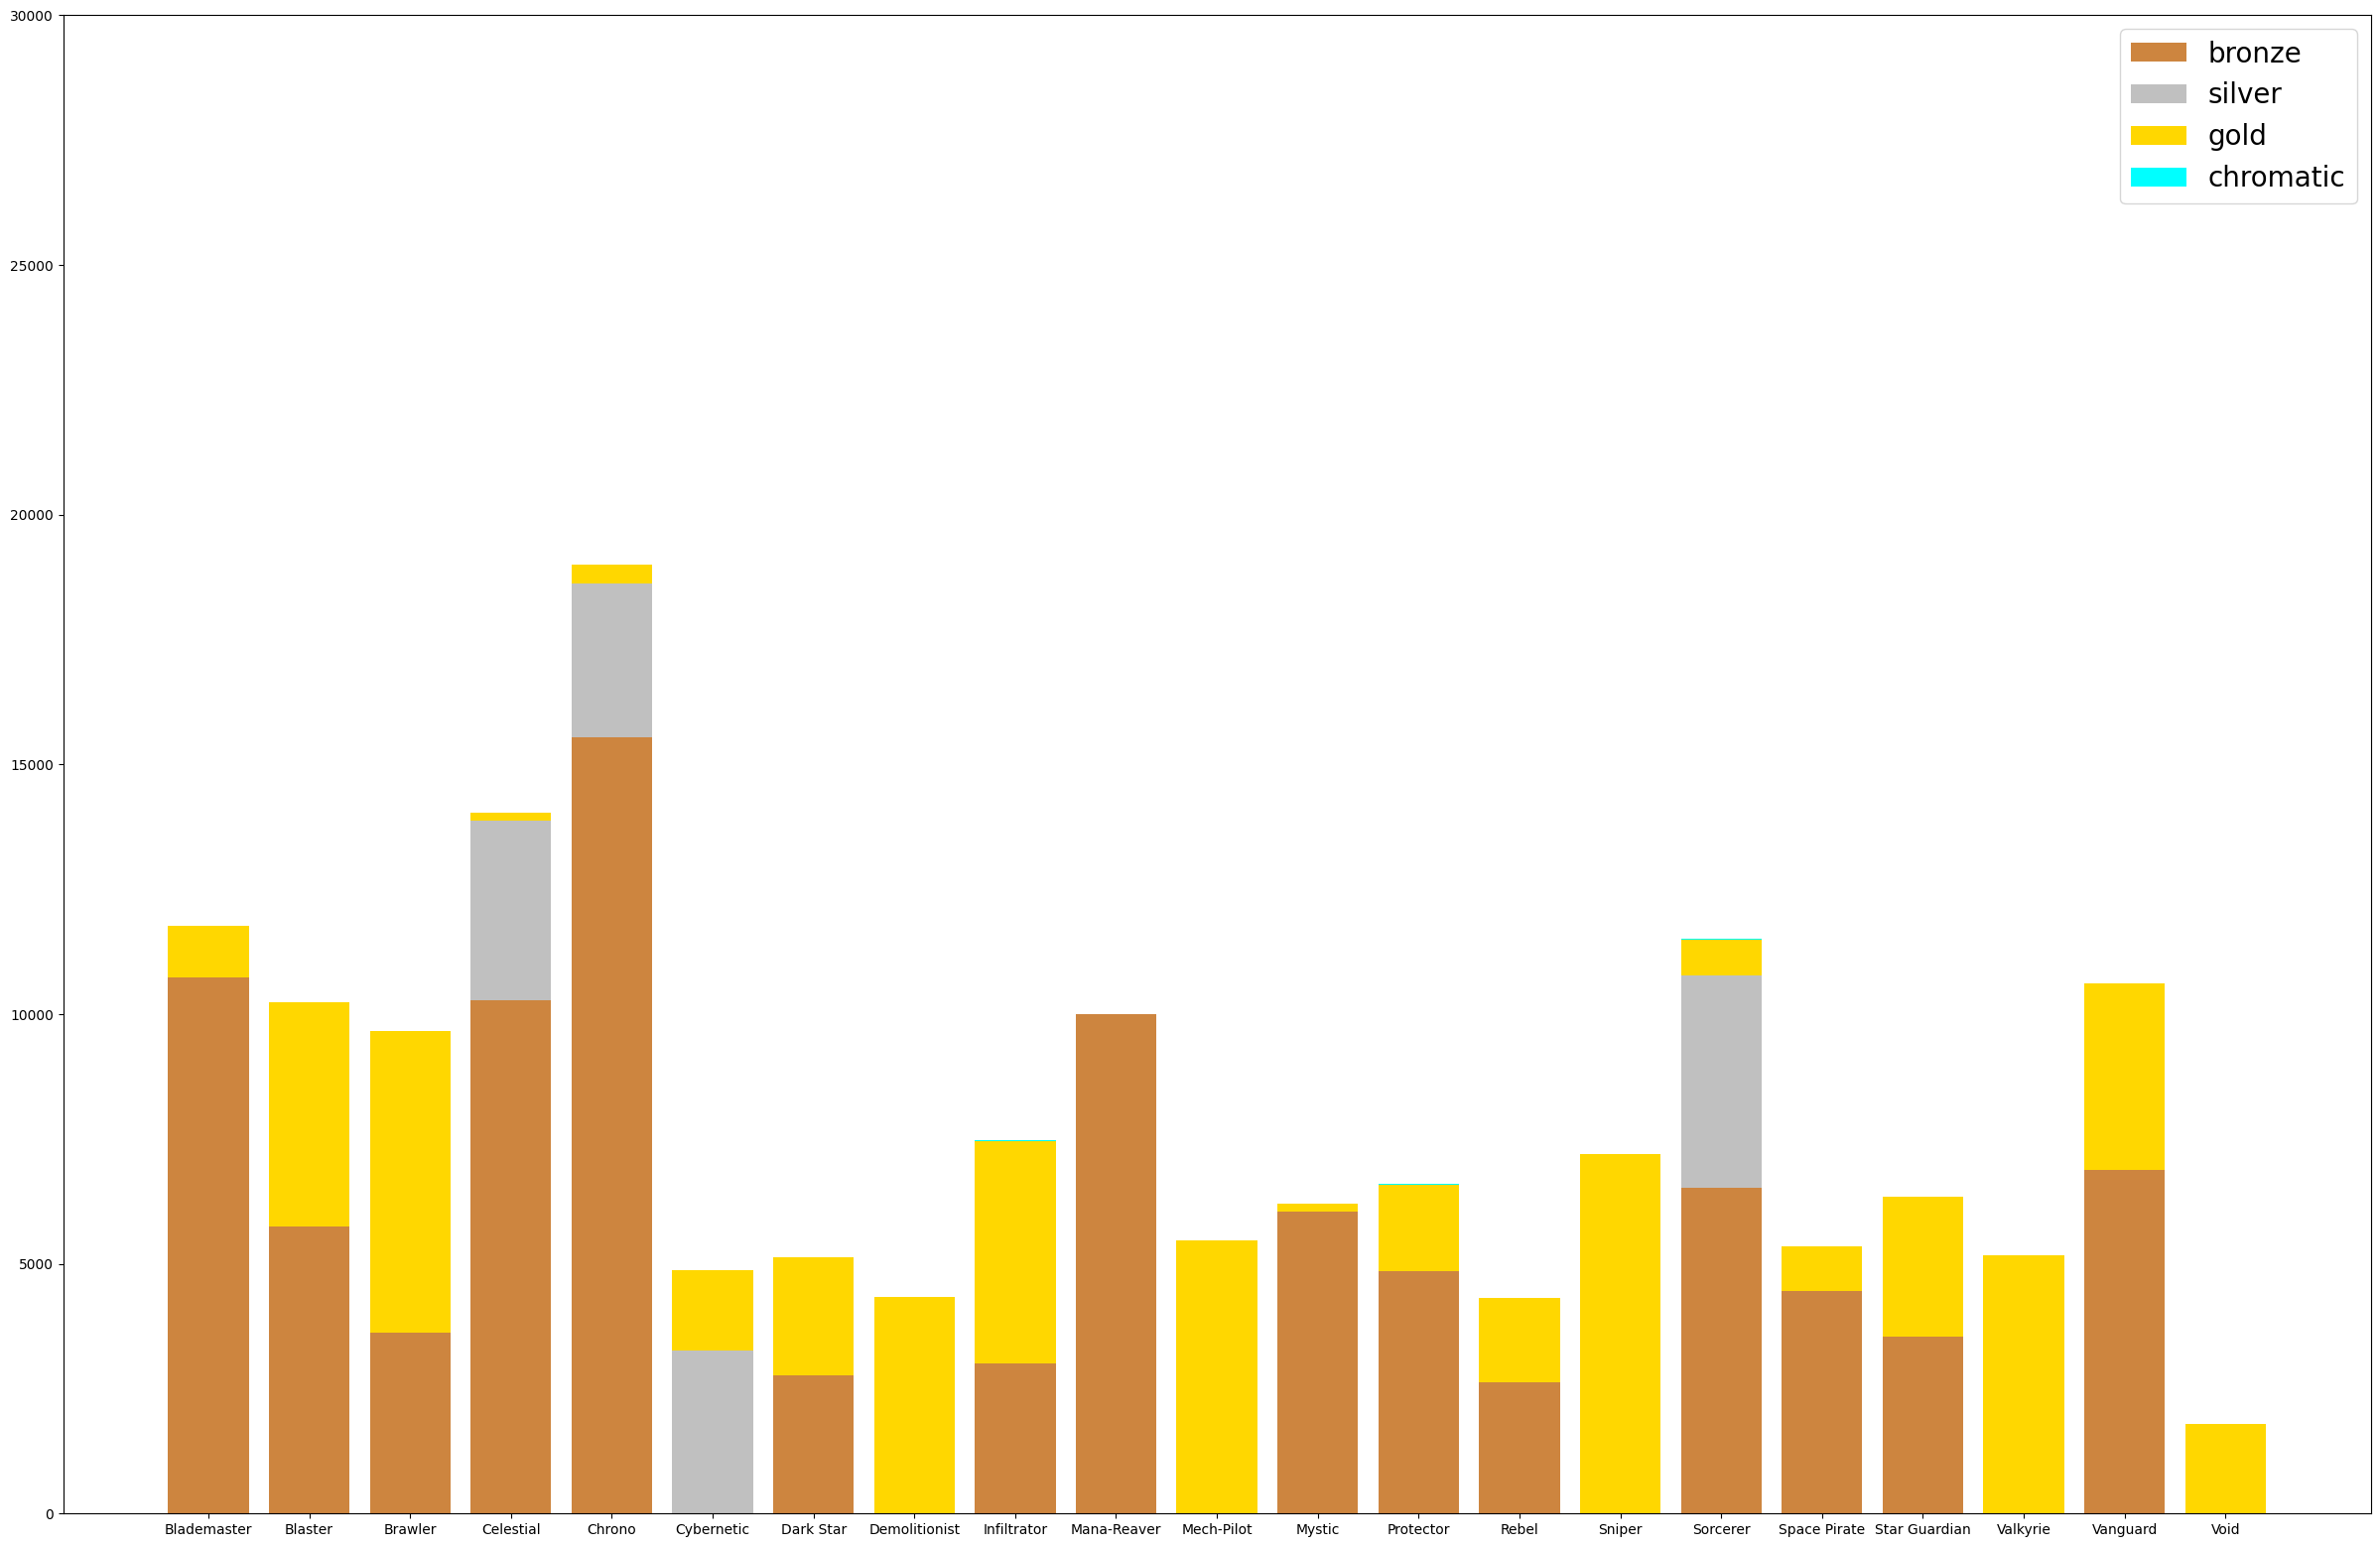

In [425]:
trait1 = []
trait2 = []
trait3 = []
trait4 = []
plt.figure(figsize = (30,20))
for trait in trait_count:
    trait1.append(trait['1'])
    trait2.append(trait['2'])
    trait3.append(trait['3'])
    trait4.append(trait['4'])
y1=np.array(trait1)
y2=np.array(trait2)
y3=np.array(trait3)
y4=np.array(trait4)
plt.bar(data_frame_traits.columns, y1, color='peru', label='bronze')
plt.bar(data_frame_traits.columns, y2, bottom=y1, color="silver", label='silver')
plt.bar(data_frame_traits.columns, y3, bottom=y1+y2, color='gold', label='gold')
plt.bar(data_frame_traits.columns, y4, bottom=y1+y2+y3, color='cyan', label='chromatic')
plt.ylim(0,30000)
plt.legend(prop={'size': 20})
plt.show()

## Primera ejecución de algoritmos

Para la ejecución de los algortimos eliminamos las columnas que nos sobran y eran necesarias para el preprocesamiento

In [22]:
first_data_frame = data_frame.drop(columns=['gameId','lastRound', 'combination', 'champion'])

In [267]:
first_data_frame

,level,position,rank,Ahri,Annie,Ashe,AurelionSol,Blitzcrank,Caitlyn,ChoGath,...,Mystic,Protector,Rebel,Sniper,Sorcerer,Space Pirate,Star Guardian,Valkyrie,Vanguard,Void
0,8,1,1,0,0,0,0,0,0,0,...,3,3,0,0,0,0,0,0,0,0
1,9,2,1,0,0,0,2,0,0,0,...,1,0,3,0,0,0,0,3,0,0
2,8,3,1,0,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,8,4,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
4,9,5,1,0,0,0,2,0,0,0,...,1,0,3,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397875,7,4,5,0,0,0,0,2,0,0,...,0,1,0,0,1,0,0,0,0,0
397876,8,5,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
397877,8,2,5,3,3,0,0,0,0,0,...,0,0,0,0,3,0,1,0,0,0
397878,8,3,5,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0


Se generan los sets de entrenamiento y pruebas

In [345]:
y = first_data_frame['position']
X = first_data_frame.drop(columns=['position'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
X_test

,level,rank,Ahri,Annie,Ashe,AurelionSol,Blitzcrank,Caitlyn,ChoGath,Darius,...,Mystic,Protector,Rebel,Sniper,Sorcerer,Space Pirate,Star Guardian,Valkyrie,Vanguard,Void
212055,7,3,0,0,1,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0
310426,8,4,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112089,8,2,0,0,2,0,0,0,0,0,...,1,0,0,3,0,0,0,0,3,0
241029,8,4,0,0,3,0,0,2,0,0,...,0,0,0,3,0,0,0,0,0,0
296219,9,4,0,0,1,0,0,0,0,0,...,0,0,0,3,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287160,8,4,0,0,2,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
45160,7,1,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
33296,9,1,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
214881,9,3,0,0,2,0,0,0,0,0,...,1,0,0,3,0,0,0,0,3,0


En este apartado se van a ejecutar distintos algoritmos de ML de los que se obtendrán sus resultados para después analizarlos.

### Decission Tree Classifier

In [326]:
decissionTree = tree.DecisionTreeClassifier(random_state=8)
decissionTree = decissionTree.fit(X_train, y_train)
decissionTree.score(X_test, y_test)

0.2522871217452498

In [125]:
predict = decissionTree.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,5,8
310426,8,7
112089,7,2
241029,3,6
296219,1,6
...,...,...
287160,7,7
45160,3,1
33296,1,1
214881,2,2


Para comprobar la calidad del algoritmo se puede mirar el valor del MAE, que da el error medio entre los datos predichos y los esperados

In [126]:
mean_absolute_error(y_test, predict)

1.4585302101136022

Se genera también la matriz de confusión para comprobar los resultados de forma más exhaustiva

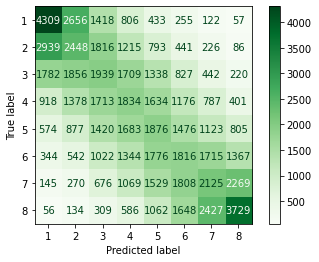

In [127]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=decissionTree.classes_)
disp.plot(cmap='Greens')
plt.show()

### Random Forest

In [128]:
randomForest = RandomForestClassifier(random_state=8)
randomForest = randomForest.fit(X_train, y_train)
randomForest.score(X_test, y_test)

0.2808258771488891

In [129]:
predict = randomForest.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,5,8
310426,8,7
112089,7,2
241029,3,6
296219,2,6
...,...,...
287160,5,7
45160,3,1
33296,1,1
214881,2,2


In [130]:
mean_absolute_error(y_test, predict)

1.340253342716397

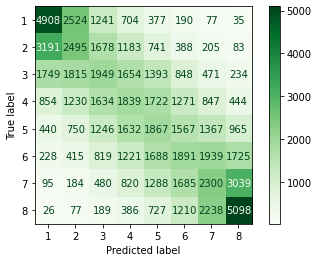

In [131]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=randomForest.classes_)
disp.plot(cmap='Greens')
plt.show()

### K Neighbors

In [327]:
neighbors = KNeighborsClassifier(n_jobs=8)
neighbors = neighbors.fit(X_train, y_train)
neighbors.score(X_test, y_test)

0.24614205288026542

In [328]:
predict = neighbors.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,5,8
310426,8,7
112089,2,2
241029,5,6
296219,1,6
...,...,...
287160,5,7
45160,4,1
33296,1,1
214881,1,2


In [329]:
mean_absolute_error(y_test, predict)

1.5502789785865085

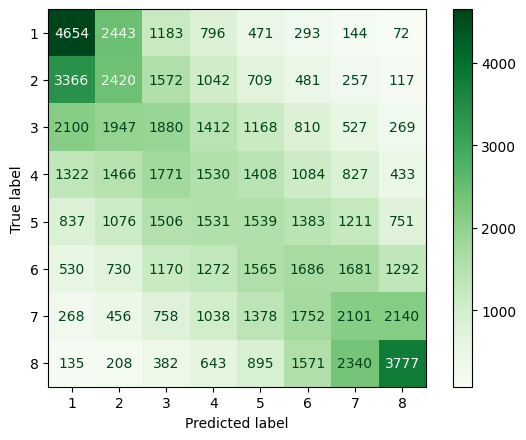

In [330]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=neighbors.classes_)
disp.plot(cmap='Greens')
plt.show()

### Nearest Centroid

In [331]:
centroid = NearestCentroid()
centroid = centroid.fit(X_train, y_train)
centroid.score(X_test, y_test)

0.2105911330049261

In [332]:
predict = centroid.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,8,8
310426,4,7
112089,6,2
241029,2,6
296219,1,6
...,...,...
287160,1,7
45160,1,1
33296,3,1
214881,1,2


In [333]:
mean_absolute_error(y_test, predict)

2.044422941590429

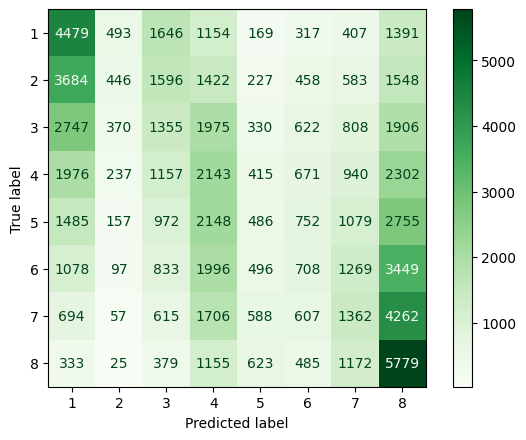

In [334]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=centroid.classes_)
disp.plot(cmap='Greens')
plt.show()

### LinearSVC

In [100]:
linear_SVC = LinearSVC(random_state=8)
linear_SVC.fit(X_train, y_train)

C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(random_state=8)

### SGDClassifier

In [335]:
SGD = SGDClassifier(n_jobs=8,random_state=8, early_stopping = True)
SGD.fit(X_train, y_train)
SGD.score(X_test,y_test)

0.22822207700814315

In [336]:
predict = SGD.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,3,8
310426,7,7
112089,7,2
241029,4,6
296219,5,6
...,...,...
287160,6,7
45160,5,1
33296,3,1
214881,4,2


In [337]:
mean_absolute_error(y_test, predict)

1.8430556951844776

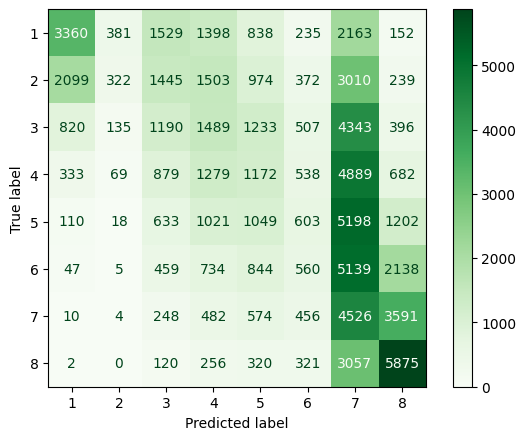

In [339]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SGD.classes_)
disp.plot(cmap='Greens')
plt.show()

### Logistic Regression

In [283]:
regression = LogisticRegression(random_state=8, n_jobs=8)
regression = regression.fit(X_train, y_train)
regression.score(X_test, y_test)

0.28169297275560473

In [284]:
predict = regression.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,5,8
310426,8,7
112089,3,2
241029,3,6
296219,2,6
...,...,...
287160,4,7
45160,3,1
33296,3,1
214881,1,2


In [285]:
mean_absolute_error(y_test, predict)

1.4164195234744144

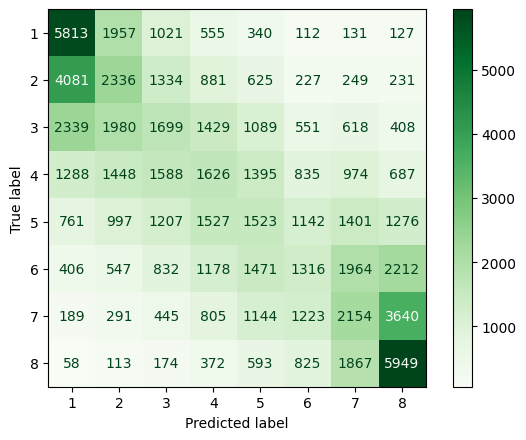

In [286]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=randomForest.classes_)
disp.plot(cmap='Greens')
plt.show()

## Grid Search primera ejecución

### Random Forest

In [65]:
randomForest = RandomForestClassifier(random_state=8)
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[20,40,60,80,100], 'max_features':['auto','sqrt'],'min_samples_leaf':[1,2,4],
              'min_samples_split':[2,5,10], 'n_estimators':[400,800,1200,1600,2000], 'bootstrap':[True,False]}
randomForest_RS = RandomizedSearchCV(randomForest, parameters, random_state = 8, n_iter = 50, cv = 2, verbose=2, n_jobs = 8)
randomForest_RS = randomForest_RS.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
39 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\joblib\parallel.py", line 1046, in __call__
    while se

In [66]:
randomForest_RS.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'gini',
 'bootstrap': True}

In [92]:
results_df = pd.DataFrame(randomForest_RS.cv_results_)
df = results_df.sort_values('mean_test_score', ascending = False)
df.iloc[:,4:]

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
7,2000,2,4,sqrt,100,gini,True,"{'n_estimators': 2000, 'min_samples_split': 2,...",0.306964,0.305796,0.306380,0.000584,1
28,800,5,4,sqrt,40,entropy,True,"{'n_estimators': 800, 'min_samples_split': 5, ...",0.306638,0.306104,0.306371,0.000267,2
41,400,5,4,auto,80,entropy,True,"{'n_estimators': 400, 'min_samples_split': 5, ...",0.306594,0.305802,0.306198,0.000396,3
47,400,10,4,auto,40,entropy,True,"{'n_estimators': 400, 'min_samples_split': 10,...",0.306531,0.305852,0.306192,0.000339,4
8,1600,5,4,auto,40,gini,False,"{'n_estimators': 1600, 'min_samples_split': 5,...",0.306261,0.305758,0.306009,0.000251,5
27,400,10,4,sqrt,40,gini,False,"{'n_estimators': 400, 'min_samples_split': 10,...",0.305551,0.305670,0.305610,0.000060,6
6,2000,10,2,sqrt,100,entropy,True,"{'n_estimators': 2000, 'min_samples_split': 10...",0.304947,0.304734,0.304841,0.000107,7
11,400,10,2,auto,100,gini,True,"{'n_estimators': 400, 'min_samples_split': 10,...",0.304526,0.304847,0.304687,0.000160,8
10,1200,5,2,sqrt,100,entropy,True,"{'n_estimators': 1200, 'min_samples_split': 5,...",0.303477,0.302849,0.303163,0.000314,9
13,400,10,4,sqrt,20,entropy,False,"{'n_estimators': 400, 'min_samples_split': 10,...",0.303163,0.301869,0.302516,0.000647,10


In [100]:
parameters = {'criterion':['gini'], 'max_depth':[40, 100, 120], 'max_features':['sqrt'],'min_samples_leaf':[4], 'min_samples_split':[1,2,3,4,5], 'n_estimators':[400,2000,2500], 'bootstrap':[True]}
randomForest_GS = GridSearchCV(randomForest, parameters, n_jobs=8)
randomForest_GS = randomForest_GS.fit(X_train, y_train)

C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
66 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\joblib\parallel.py", line 1043, in __call__
    if self

In [103]:
randomForest_GS.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 120,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 2500}

### Decission Tree

In [106]:
decissionTree = tree.DecisionTreeClassifier(random_state=8)
parameters = {'criterion':('gini', 'entropy'), 'splitter':('best', 'random'), 'max_depth':[20,40,60,80,100], 'max_features':['auto','sqrt'],'min_samples_leaf':[1,2,4],
              'min_samples_split':[2,5,10]}
decissionTree_RS = RandomizedSearchCV(decissionTree, parameters, random_state = 8, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
decissionTree_RS = decissionTree_RS.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [107]:
decissionTree_RS.best_params_

{'splitter': 'best',
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 40,
 'criterion': 'gini'}

In [158]:
decissionTree = tree.DecisionTreeClassifier(random_state=8)
parameters = {'criterion':['gini'], 'splitter':['best'], 'max_depth':[30,40,50], 'max_features':['sqrt'],'min_samples_leaf':[3,4,5], 'min_samples_split':[1,2,3]}
decissionTree_GS = GridSearchCV(decissionTree, parameters, n_jobs=-1, verbose=2)
decissionTree_GS = decissionTree_GS.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\tree\_classes.py", line 254, in fit
    % self.min_s

In [159]:
decissionTree_GS.best_params_

{'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'splitter': 'best'}

### Logistic Regression

In [114]:
regression = LogisticRegression(random_state=8, n_jobs=8)
parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear'), 'penalty':('none', 'l1', 'l2', 'elasticnet'), 'C':loguniform(1e-5, 100)}
regression_RS = RandomizedSearchCV(regression, parameters, random_state = 8, n_iter = 25, cv = 2, verbose=2, n_jobs = 8)
regression_RS = regression_RS.fit(X_train, y_train)

Fitting 2 folds for each of 25 candidates, totalling 50 fits


C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
28 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_mod

In [115]:
regression_RS.best_params_

{'C': 21.839648844407012, 'penalty': 'l2', 'solver': 'newton-cg'}

In [160]:
regression = LogisticRegression(random_state=8, n_jobs=8)
parameters = {'solver':['newton-cg'], 'penalty':['l2'], 'C':[20,21,22,23,24]}
regression_GS = GridSearchCV(regression, parameters, n_jobs=-1, verbose=2)
regression_GS = regression_GS.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [161]:
regression_GS.best_params_

{'C': 23, 'penalty': 'l2', 'solver': 'newton-cg'}

## Resultados tras Grid Search

### Random Forest RS

In [118]:
randomForest = RandomForestClassifier(random_state=8, n_estimators=2000, min_samples_split=2, min_samples_leaf=4,
                                            max_features='sqrt', max_depth=100, criterion='gini', bootstrap=True)
randomForest = randomForest.fit(X_train, y_train)
randomForest.score(X_test, y_test)

0.30894993465366444

In [119]:
predict = randomForest.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,5,8
310426,8,7
112089,4,2
241029,3,6
296219,2,6
...,...,...
287160,5,7
45160,1,1
33296,1,1
214881,1,2


In [121]:
mean_absolute_error(y_test, predict)

1.2272795817834523

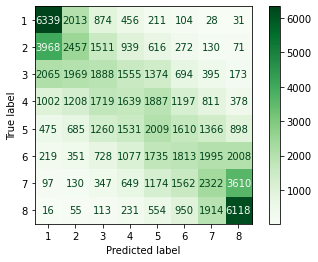

In [122]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=randomForest.classes_)
disp.plot(cmap='Greens')
plt.show()

### Random Forest GS

In [162]:
randomForest = RandomForestClassifier(random_state=8, n_estimators=2500, min_samples_split=3, min_samples_leaf=4,
                                            max_features='sqrt', max_depth=120, criterion='gini', bootstrap=True)
randomForest = randomForest.fit(X_train, y_train)
randomForest.score(X_test, y_test)

0.30892480144767265

In [163]:
predict = randomForest.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,5,8
310426,8,7
112089,4,2
241029,3,6
296219,2,6
...,...,...
287160,5,7
45160,1,1
33296,1,1
214881,1,2


In [164]:
mean_absolute_error(y_test, predict)

1.2277068462853122

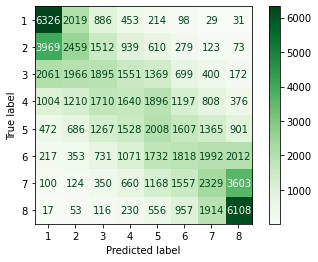

In [165]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=randomForest.classes_)
disp.plot(cmap='Greens')
plt.show()

### Decission Tree

In [149]:
decissionTree = tree.DecisionTreeClassifier(random_state=8, splitter='best', min_samples_split=2, min_samples_leaf=4,
 max_features='sqrt', max_depth=40, criterion='gini')
decissionTree = decissionTree.fit(X_train, y_train)
decissionTree.score(X_test, y_test)

0.275987734995476

In [150]:
predict = decissionTree.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,5,8
310426,8,7
112089,5,2
241029,3,6
296219,1,6
...,...,...
287160,5,7
45160,1,1
33296,1,1
214881,1,2


Para comprobar la calidad del algoritmo se puede mirar el valor del MAE, que da el error medio entre los datos predichos y los esperados

In [151]:
mean_absolute_error(y_test, predict)

1.3875163365838947

Se genera también la matriz de confusión para comprobar los resultados de forma más exhaustiva

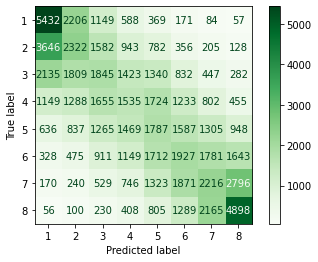

In [152]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=decissionTree.classes_)
disp.plot(cmap='Greens')
plt.show()

### Logistic Regression RS

In [346]:
regression = LogisticRegression(random_state=8, n_jobs=8, C=21.839648844407012, penalty='l2', solver='newton-cg')
regression = regression.fit(X_train, y_train)
regression.score(X_test, y_test)

0.3019252035789685

In [347]:
predict = regression.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,6,8
310426,7,7
112089,5,2
241029,4,6
296219,2,6
...,...,...
287160,4,7
45160,3,1
33296,2,1
214881,1,2


In [348]:
mean_absolute_error(y_test, predict)

1.2473861465768574

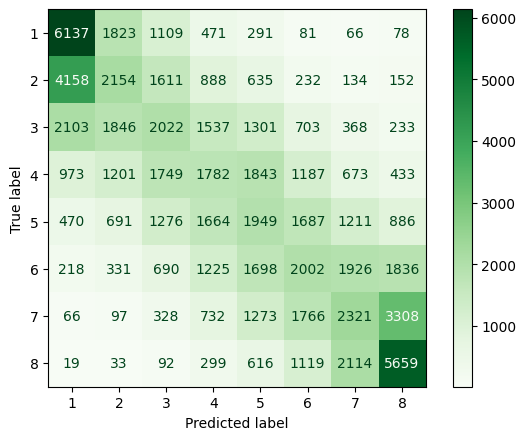

In [349]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regression.classes_)
disp.plot(cmap='Greens')
plt.show()

### Logistic Regression GS

In [166]:
regression = LogisticRegression(random_state=8, n_jobs=8, C=23, penalty='l2', solver='newton-cg')
regression = regression.fit(X_train, y_train)
regression.score(X_test, y_test)

0.3019252035789685

In [167]:
predict = regression.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,6,8
310426,7,7
112089,5,2
241029,4,6
296219,2,6
...,...,...
287160,4,7
45160,3,1
33296,2,1
214881,1,2


In [168]:
mean_absolute_error(y_test, predict)

1.2473861465768574

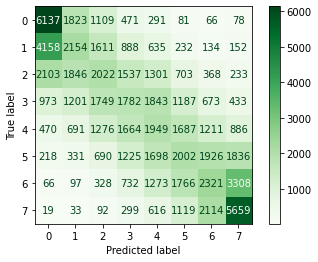

In [169]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.show()

## Comprobación sin nivel

Comprobación de que el nivel no influye más de lo necesario

In [171]:
alt_df = first_data_frame.drop(columns=['level'])

In [172]:
y = alt_df['position']
X = alt_df.drop(columns=['position'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
X_test

,rank,Ahri,Annie,Ashe,AurelionSol,Blitzcrank,Caitlyn,ChoGath,Darius,Ekko,...,Mystic,Protector,Rebel,Sniper,Sorcerer,Space Pirate,Star Guardian,Valkyrie,Vanguard,Void
212055,3,0,0,1,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0
310426,4,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112089,2,0,0,2,0,0,0,0,0,0,...,1,0,0,3,0,0,0,0,3,0
241029,4,0,0,3,0,0,2,0,0,0,...,0,0,0,3,0,0,0,0,0,0
296219,4,0,0,1,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287160,4,0,0,2,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
45160,1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
33296,1,0,0,0,0,2,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
214881,3,0,0,2,0,0,0,0,0,0,...,1,0,0,3,0,0,0,0,3,0


In [173]:
randomForest = RandomForestClassifier(random_state=8, n_estimators=2000, min_samples_split=2, min_samples_leaf=4,
                                            max_features='sqrt', max_depth=100, criterion='gini', bootstrap=True)
randomForest = randomForest.fit(X_train, y_train)
randomForest.score(X_test, y_test)

0.30110837438423643

In [174]:
predict = randomForest.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
212055,5,8
310426,8,7
112089,5,2
241029,3,6
296219,2,6
...,...,...
287160,5,7
45160,1,1
33296,1,1
214881,1,2


In [175]:
mean_absolute_error(y_test, predict)

1.3047275560470493

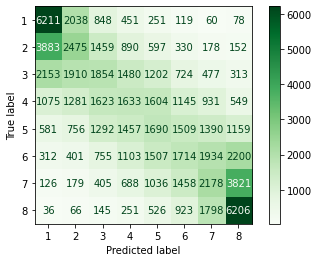

In [176]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=randomForest.classes_)
disp.plot(cmap='Greens')
plt.show()

## Segunda versión de preprocesamiento

Ahora vamos a almacenar en cada columna el coste del campeón

Para ello primero se comprueba cuántas columnas son necesarias, calculando el máximo de campeones existente

In [231]:
max_count = 0
for champs_df in data_frame['champion']:
    champs_df = champs_df.replace("'",'"') 
    champs_df = json.loads(champs_df)
    count = 0
    for key in champs_df:
        count += 1
    if max_count < count:
        max_count = count
print(f'El número máximo de campeones en un equipo en el dataframe es {max_count}')

El número máximo de campeones en un equipo en el dataframe es 12


In [232]:
champions_list = ['champion' + str(i) for i in range(1,13)]

In [233]:
def cost(champ_df):
    if champ_df['star'] == 1:
        star_cost = 1
    elif champ_df['star'] == 2:
        star_cost = 3
    elif champ_df['star'] == 3:
        star_cost = 9
    return star_cost
all_champions = []
for champs_df in data_frame['champion']:
    champs_df = champs_df.replace("'",'"') 
    champs_df = json.loads(champs_df)
    new_row = { i : 0 for i in champ_names }
    champions = []
    for key in champs_df:
        champ_df=champs_df[key]
        cost_condition = [ champ_json['cost']*cost(champ_df) for champ_json in champions_json if key == champ_json['name']]
        champions.append(0 if len(cost_condition)==0 else cost_condition[0]);
    all_champions.append(champions)

Borramos las columnas de los campeones anteriores y guardamos las nuevas

In [234]:
data_frame = data_frame.drop(columns=champ_names)
new_champs_df = pd.DataFrame(all_champions, columns=champions_list).fillna(0)
data_frame.reset_index(drop=True, inplace=True)
data_frame = data_frame.join(new_champs_df).reset_index(drop=True)
data_frame

,gameId,level,lastRound,position,combination,champion,rank,Blademaster,Blaster,Brawler,...,champion3,champion4,champion5,champion6,champion7,champion8,champion9,champion10,champion11,champion12
0,KR_4247538593,8,35,1,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': {'items': [27], 'star': 3}, 'Sona...",1,0,0,0,...,18.0,18.0,9.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0
1,KR_4247538593,9,35,2,"{'Blaster': 2, 'Mercenary': 1, 'Rebel': 6, 'Se...","{'Malphite': {'items': [7], 'star': 2}, 'Yasuo...",1,1,1,0,...,6.0,3.0,12.0,12.0,12.0,5.0,15.0,0.0,0.0,0.0
2,KR_4247538593,8,34,3,"{'Cybernetic': 1, 'DarkStar': 3, 'Demolitionis...","{'KaiSa': {'items': [99, 2, 23], 'star': 2}, '...",1,0,0,0,...,9.0,27.0,9.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0
3,KR_4247538593,8,33,4,"{'Blaster': 1, 'Cybernetic': 1, 'DarkStar': 1,...","{'KaiSa': {'items': [44, 37], 'star': 2}, 'Ann...",1,0,0,0,...,9.0,9.0,12.0,5.0,15.0,5.0,0.0,0.0,0.0,0.0
4,KR_4247538593,9,33,5,"{'Blaster': 2, 'Demolitionist': 2, 'Mercenary'...","{'Ziggs': {'items': [], 'star': 1}, 'Yasuo': {...",1,0,1,0,...,2.0,9.0,4.0,15.0,5.0,15.0,15.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397875,KR_4296831363,7,34,4,"{'Chrono': 2, 'Cybernetic': 1, 'Protector': 2,...","{'TwistedFate': {'items': [58], 'star': 2}, 'X...",5,0,0,1,...,6.0,6.0,9.0,9.0,4.0,0.0,0.0,0.0,0.0,0.0
397876,KR_4296831363,8,33,5,"{'Chrono': 2, 'Cybernetic': 1, 'Infiltrator': ...","{'Xayah': {'items': [5], 'star': 2}, 'Yasuo': ...",5,3,0,0,...,18.0,6.0,9.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0
397877,KR_4296831363,8,38,2,"{'Blaster': 1, 'DarkStar': 1, 'MechPilot': 1, ...","{'Poppy': {'items': [], 'star': 2}, 'Zoe': {'i...",5,0,0,0,...,18.0,18.0,27.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0
397878,KR_4296831363,8,35,3,"{'Blaster': 2, 'Chrono': 1, 'Demolitionist': 1...","{'Ziggs': {'items': [44, 48], 'star': 3}, 'Mal...",5,1,1,0,...,18.0,6.0,18.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0


Se generan dos nuevas columnas que contendrán la información del coste total del equipo y el número de campeones de este

In [235]:
#Calculo del coste del equipo
def cost(champ_df):
    if champ_df['star'] == 1:
        star_cost = 1
    elif champ_df['star'] == 2:
        star_cost = 3
    elif champ_df['star'] == 3:
        star_cost = 9
    return star_cost
cost_list = []
for champs_df in data_frame['champion']:
    total_cost = 0
    champs_df = champs_df.replace("'",'"') 
    champs_df = json.loads(champs_df)
    for key in champs_df:
        champ_df=champs_df[key]
        total_cost += sum([ champ_json['cost']*cost(champ_df) for champ_json in champions_json if key == champ_json['name'] ])      
    cost_list.append(total_cost)
data_frame['teamCost'] = cost_list

In [236]:
#Calculo del número de campeones del equipo
num_champs_list = []
for champs_df in data_frame['champion']:
    champs_df = champs_df.replace("'",'"') 
    champs_df = json.loads(champs_df)
    new_row = { i : 0 for i in champ_names }
    num_champs = 0
    for key in champs_df:
        num_champs += 1
    num_champs_list.append(num_champs)
data_frame['championNumber'] = num_champs_list

Se ha decidido generar los siguientes gráficos para ver los valores por posición

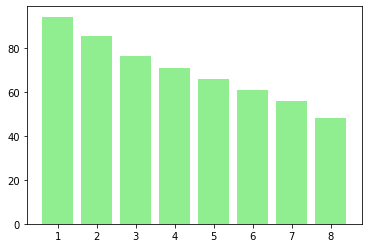

In [237]:
avg_costs = [data_frame[data_frame['position'] == i]['teamCost'].mean() for i in range(1,9)]
plt.bar(data_frame['position'].unique(), avg_costs, color = 'lightgreen')
plt.show()

Vemos que el coste total del equipo sí es relevante ya que la media de coste aumenta en función de la posición.

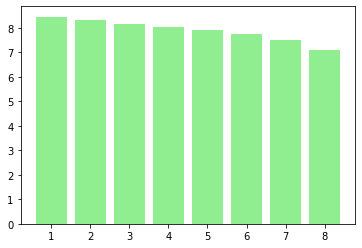

In [238]:
avg_champs = [data_frame[data_frame['position'] == i]['championNumber'].mean() for i in range(1,9)]
plt.bar(data_frame['position'].unique(), avg_champs, color = 'lightgreen')
plt.show()

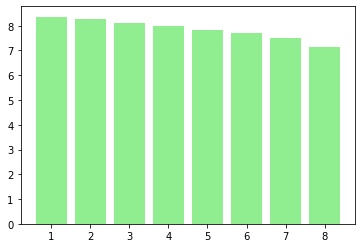

In [239]:
avg_level = [data_frame[data_frame['position'] == i]['level'].mean() for i in range(1,9)]
plt.bar(data_frame['position'].unique(), avg_level, color = 'lightgreen')
plt.show()

Se plantea la hipótesis de que el valor de las sinergias sea relevante, por lo que se calcula la suma del valor de las sinergias para cada jugador

In [240]:
sum_list = []
for index, row in new_trait_df.iterrows():
    sum_traits = 0
    for trait in row:
        sum_traits += trait
    sum_list.append(sum_traits)

In [241]:
#Prueba para ver si el valor de las sinergias es relevante
data_frame['traitsValue'] = sum_list
data_frame

,gameId,level,lastRound,position,combination,champion,rank,Blademaster,Blaster,Brawler,...,champion6,champion7,champion8,champion9,champion10,champion11,champion12,teamCost,championNumber,traitsValue
0,KR_4247538593,8,35,1,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': {'items': [27], 'star': 3}, 'Sona...",1,0,0,0,...,9.0,12.0,5.0,0.0,0.0,0.0,0.0,98,8,7
1,KR_4247538593,9,35,2,"{'Blaster': 2, 'Mercenary': 1, 'Rebel': 6, 'Se...","{'Malphite': {'items': [7], 'star': 2}, 'Yasuo...",1,1,1,0,...,12.0,12.0,5.0,15.0,0.0,0.0,0.0,74,9,9
2,KR_4247538593,8,34,3,"{'Cybernetic': 1, 'DarkStar': 3, 'Demolitionis...","{'KaiSa': {'items': [99, 2, 23], 'star': 2}, '...",1,0,0,0,...,9.0,12.0,5.0,0.0,0.0,0.0,0.0,83,8,8
3,KR_4247538593,8,33,4,"{'Blaster': 1, 'Cybernetic': 1, 'DarkStar': 1,...","{'KaiSa': {'items': [44, 37], 'star': 2}, 'Ann...",1,0,0,0,...,5.0,15.0,5.0,0.0,0.0,0.0,0.0,67,8,12
4,KR_4247538593,9,33,5,"{'Blaster': 2, 'Demolitionist': 2, 'Mercenary'...","{'Ziggs': {'items': [], 'star': 1}, 'Yasuo': {...",1,0,1,0,...,15.0,5.0,15.0,15.0,0.0,0.0,0.0,68,9,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397875,KR_4296831363,7,34,4,"{'Chrono': 2, 'Cybernetic': 1, 'Protector': 2,...","{'TwistedFate': {'items': [58], 'star': 2}, 'X...",5,0,0,1,...,9.0,4.0,0.0,0.0,0.0,0.0,0.0,40,7,5
397876,KR_4296831363,8,33,5,"{'Chrono': 2, 'Cybernetic': 1, 'Infiltrator': ...","{'Xayah': {'items': [5], 'star': 2}, 'Yasuo': ...",5,3,0,0,...,12.0,12.0,12.0,0.0,0.0,0.0,0.0,74,8,7
397877,KR_4296831363,8,38,2,"{'Blaster': 1, 'DarkStar': 1, 'MechPilot': 1, ...","{'Poppy': {'items': [], 'star': 2}, 'Zoe': {'i...",5,0,0,0,...,9.0,12.0,5.0,0.0,0.0,0.0,0.0,95,8,4
397878,KR_4296831363,8,35,3,"{'Blaster': 2, 'Chrono': 1, 'Demolitionist': 1...","{'Ziggs': {'items': [44, 48], 'star': 3}, 'Mal...",5,1,1,0,...,9.0,12.0,5.0,0.0,0.0,0.0,0.0,80,8,5


Se eliminan las filas que tengan menos de 6 campeones

In [244]:
min_champs = data_frame[data_frame['championNumber']<6]
data_frame.drop(index=min_champs.index, inplace=True)
data_frame.drop(columns=['championNumber'], inplace=True)
data_frame.reset_index(drop=True, inplace=True)
data_frame

,gameId,level,lastRound,position,combination,champion,rank,Blademaster,Blaster,Brawler,...,champion5,champion6,champion7,champion8,champion9,champion10,champion11,champion12,teamCost,traitsValue
0,KR_4247538593,8,35,1,"{'DarkStar': 2, 'Protector': 4, 'Rebel': 1, 'S...","{'JarvanIV': {'items': [27], 'star': 3}, 'Sona...",1,0,0,0,...,9.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,98,7
1,KR_4247538593,9,35,2,"{'Blaster': 2, 'Mercenary': 1, 'Rebel': 6, 'Se...","{'Malphite': {'items': [7], 'star': 2}, 'Yasuo...",1,1,1,0,...,12.0,12.0,12.0,5.0,15.0,0.0,0.0,0.0,74,9
2,KR_4247538593,8,34,3,"{'Cybernetic': 1, 'DarkStar': 3, 'Demolitionis...","{'KaiSa': {'items': [99, 2, 23], 'star': 2}, '...",1,0,0,0,...,9.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,83,8
3,KR_4247538593,8,33,4,"{'Blaster': 1, 'Cybernetic': 1, 'DarkStar': 1,...","{'KaiSa': {'items': [44, 37], 'star': 2}, 'Ann...",1,0,0,0,...,12.0,5.0,15.0,5.0,0.0,0.0,0.0,0.0,67,12
4,KR_4247538593,9,33,5,"{'Blaster': 2, 'Demolitionist': 2, 'Mercenary'...","{'Ziggs': {'items': [], 'star': 1}, 'Yasuo': {...",1,0,1,0,...,4.0,15.0,5.0,15.0,15.0,0.0,0.0,0.0,68,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393522,KR_4296831363,7,34,4,"{'Chrono': 2, 'Cybernetic': 1, 'Protector': 2,...","{'TwistedFate': {'items': [58], 'star': 2}, 'X...",5,0,0,1,...,9.0,9.0,4.0,0.0,0.0,0.0,0.0,0.0,40,5
393523,KR_4296831363,8,33,5,"{'Chrono': 2, 'Cybernetic': 1, 'Infiltrator': ...","{'Xayah': {'items': [5], 'star': 2}, 'Yasuo': ...",5,3,0,0,...,9.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,74,7
393524,KR_4296831363,8,38,2,"{'Blaster': 1, 'DarkStar': 1, 'MechPilot': 1, ...","{'Poppy': {'items': [], 'star': 2}, 'Zoe': {'i...",5,0,0,0,...,27.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,95,4
393525,KR_4296831363,8,35,3,"{'Blaster': 2, 'Chrono': 1, 'Demolitionist': 1...","{'Ziggs': {'items': [44, 48], 'star': 3}, 'Mal...",5,1,1,0,...,18.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,80,5


Se comprueba la media del valor de sinergias por posición para ver si es un dato relevante

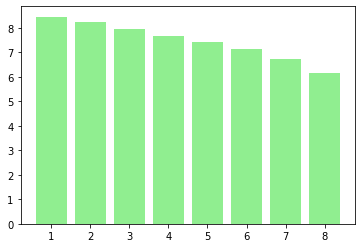

In [245]:
avg_traits = [data_frame[data_frame['position'] == i]['traitsValue'].mean() for i in range(1,9)]
avg_traits
plt.bar(data_frame['position'].unique(), avg_traits, color='lightgreen')
plt.show()

Distribución del valor de sinergias de todo el dataframe

In [250]:
data_frame['traitsValue'].mean()

7.492388069941834

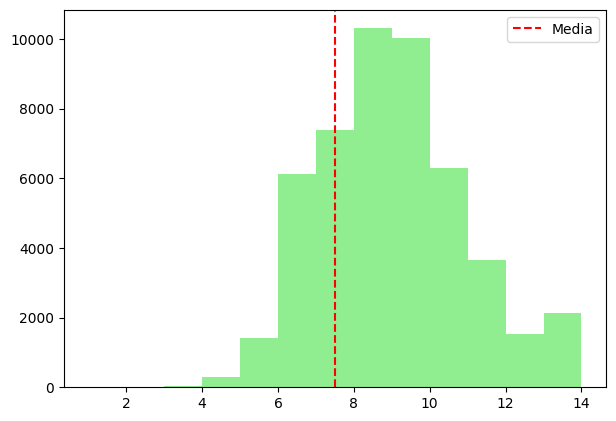

In [263]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.hist(data_frame['traitsValue'][data_frame['position']==1], bins = [i for i in range(1,15)], color='lightgreen')
plt.axvline(x=data_frame['traitsValue'].mean(), linestyle='--', color = 'r', label = r"Media")
plt.legend()

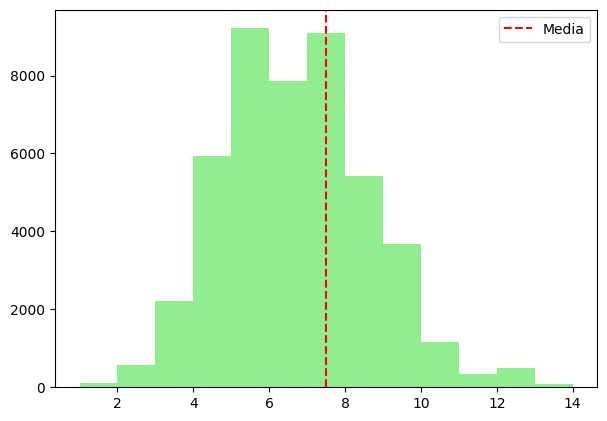

In [264]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.hist(data_frame['traitsValue'][data_frame['position']==8], bins = [i for i in range(1,15)], color='lightgreen')
plt.axvline(x=data_frame['traitsValue'].mean(), linestyle='--', color = 'r', label = r"Media")
plt.legend()

## Segunda ejecución de algoritmos

In [268]:
second_data_frame = data_frame.drop(columns=['gameId','lastRound', 'combination', 'champion'])

In [269]:
second_data_frame

,level,position,rank,Blademaster,Blaster,Brawler,Celestial,Chrono,Cybernetic,Dark Star,...,champion5,champion6,champion7,champion8,champion9,champion10,champion11,champion12,teamCost,traitsValue
0,8,1,1,0,0,0,1,0,0,0,...,9.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,98,7
1,9,2,1,1,1,0,0,0,0,0,...,12.0,12.0,12.0,5.0,15.0,0.0,0.0,0.0,74,9
2,8,3,1,0,0,0,0,0,0,1,...,9.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,83,8
3,8,4,1,0,0,0,0,0,0,0,...,12.0,5.0,15.0,5.0,0.0,0.0,0.0,0.0,67,12
4,9,5,1,0,1,0,0,0,0,0,...,4.0,15.0,5.0,15.0,15.0,0.0,0.0,0.0,68,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393522,7,4,5,0,0,1,1,1,0,0,...,9.0,9.0,4.0,0.0,0.0,0.0,0.0,0.0,40,5
393523,8,5,5,3,0,0,0,1,0,0,...,9.0,12.0,12.0,12.0,0.0,0.0,0.0,0.0,74,7
393524,8,2,5,0,0,0,0,0,0,0,...,27.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,95,4
393525,8,3,5,1,1,0,0,0,0,0,...,18.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,80,5


In [350]:
y = second_data_frame['position']
X = second_data_frame.drop(columns=['position'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
X_test

,level,rank,Blademaster,Blaster,Brawler,Celestial,Chrono,Cybernetic,Dark Star,Demolitionist,...,champion5,champion6,champion7,champion8,champion9,champion10,champion11,champion12,teamCost,traitsValue
14154,8,1,0,0,0,0,0,0,0,3,...,3.0,3.0,12.0,15.0,0.0,0.0,0.0,0.0,47,7
132293,7,2,0,0,0,0,0,0,0,3,...,9.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,97,13
39131,8,1,0,0,0,1,0,0,0,0,...,18.0,27.0,12.0,12.0,0.0,0.0,0.0,0.0,120,6
346831,8,5,0,0,0,0,0,0,0,0,...,9.0,27.0,12.0,12.0,0.0,0.0,0.0,0.0,90,7
159232,8,3,0,0,0,0,0,0,0,0,...,9.0,12.0,4.0,0.0,0.0,0.0,0.0,0.0,41,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198324,7,3,0,0,0,2,0,0,0,0,...,3.0,9.0,12.0,0.0,0.0,0.0,0.0,0.0,71,10
155383,7,2,1,0,1,1,1,0,0,0,...,2.0,4.0,12.0,0.0,0.0,0.0,0.0,0.0,48,5
369829,7,5,0,0,0,1,0,0,0,0,...,9.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,99,7
238184,7,4,1,0,0,1,1,0,0,0,...,6.0,9.0,12.0,0.0,0.0,0.0,0.0,0.0,60,5


### Decission Tree Classifier

In [309]:
decissionTree = tree.DecisionTreeClassifier(random_state=8)
decissionTree = decissionTree.fit(X_train, y_train)
decissionTree.score(X_test, y_test)

0.2547328030899804

In [310]:
predict = decissionTree.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
14154,7,8
132293,4,3
39131,2,1
346831,4,4
159232,7,4
...,...,...
198324,7,6
155383,8,8
369829,3,5
238184,6,5


Para comprobar la calidad del algoritmo se puede mirar el valor del MAE, que da el error medio entre los datos predichos y los esperados

In [273]:
mean_absolute_error(y_test, predict)

1.4183162655960155

Se genera también la matriz de confusión para comprobar los resultados de forma más exhaustiva

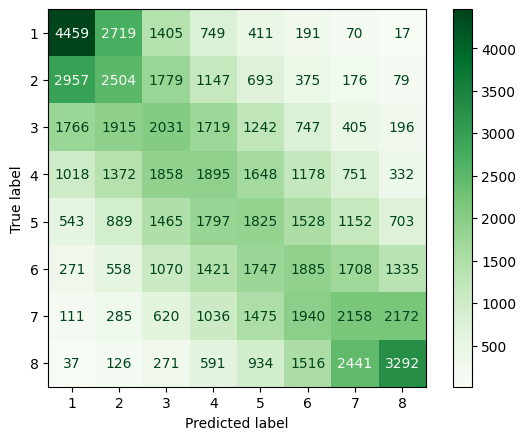

In [274]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=decissionTree.classes_)
disp.plot(cmap='Greens')
plt.show()

### Random Forest

In [275]:
randomForest = RandomForestClassifier(random_state=8)
randomForest = randomForest.fit(X_train, y_train)
randomForest.score(X_test, y_test)

0.2837648972124107

In [276]:
predict = randomForest.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
14154,8,8
132293,4,3
39131,1,1
346831,4,4
159232,8,4
...,...,...
198324,5,6
155383,7,8
369829,3,5
238184,7,5


In [277]:
mean_absolute_error(y_test, predict)

1.2929763931593525

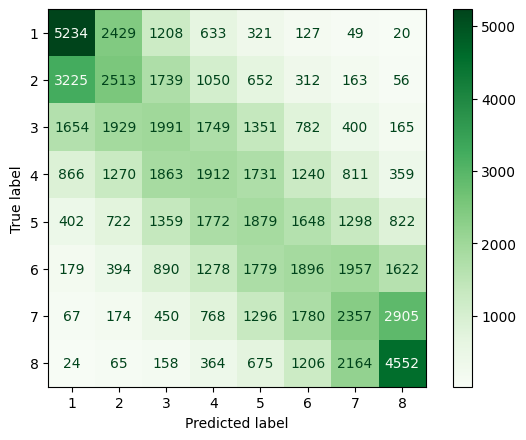

In [278]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=randomForest.classes_)
disp.plot(cmap='Greens')
plt.show()

### Logistic Regression

In [288]:
regression = LogisticRegression(random_state=8, n_jobs=8)
regression = regression.fit(X_train, y_train)
regression.score(X_test, y_test)

0.2698650674662669

In [289]:
predict = regression.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
14154,5,8
132293,1,3
39131,1,1
346831,1,4
159232,8,4
...,...,...
198324,6,6
155383,7,8
369829,4,5
238184,7,5


In [290]:
mean_absolute_error(y_test, predict)

1.4694686555027572

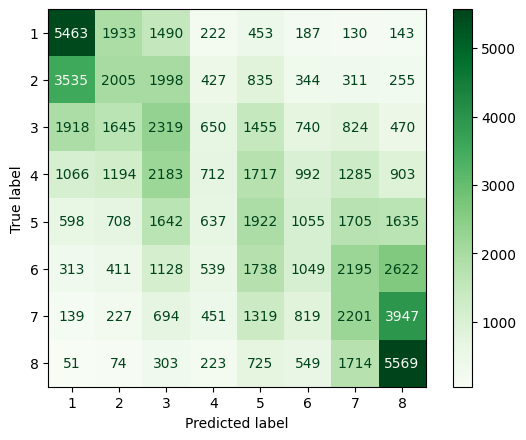

In [291]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=randomForest.classes_)
disp.plot(cmap='Greens')
plt.show()

### K Neighbors

In [292]:
neighbors = KNeighborsClassifier(n_jobs=8)
neighbors = neighbors.fit(X_train, y_train)
neighbors.score(X_test, y_test)

0.26263563133687395

In [293]:
predict = neighbors.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
14154,8,8
132293,1,3
39131,2,1
346831,3,4
159232,7,4
...,...,...
198324,7,6
155383,7,8
369829,3,5
238184,6,5


In [294]:
mean_absolute_error(y_test, predict)

1.4190785962950727

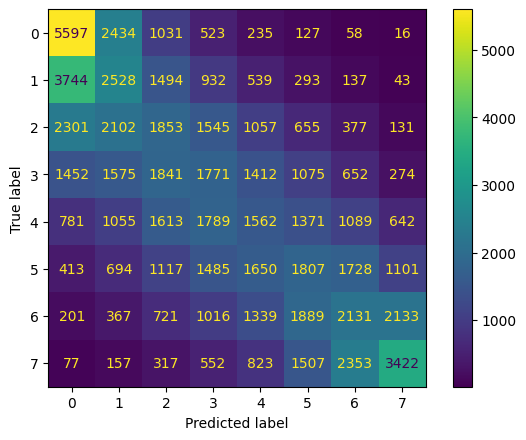

In [295]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Nearest Centroid

In [296]:
centroid = NearestCentroid()
centroid = centroid.fit(X_train, y_train)
centroid.score(X_test, y_test)

0.27297791782075065

In [297]:
predict = centroid.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
14154,8,8
132293,1,3
39131,1,1
346831,1,4
159232,8,4
...,...,...
198324,4,6
155383,8,8
369829,1,5
238184,6,5


In [298]:
mean_absolute_error(y_test, predict)

1.4322288008538104

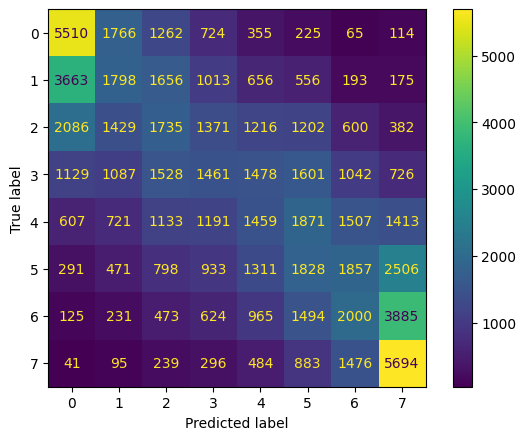

In [299]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### LinearSVC

In [300]:
linear_SVC = LinearSVC(random_state=8)
linear_SVC.fit(X_train, y_train)

C:\Users\juany\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(random_state=8)

### SGDClassifier

In [301]:
SGD = SGDClassifier(n_jobs=8,random_state=8, early_stopping = True)
SGD.fit(X_train, y_train)
SGD.score(X_test,y_test)

0.2292582522298173

In [302]:
predict = SGD.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
14154,8,8
132293,3,3
39131,1,1
346831,3,4
159232,3,4
...,...,...
198324,3,6
155383,6,8
369829,3,5
238184,3,5


In [303]:
mean_absolute_error(y_test, predict)

1.7369959088252485

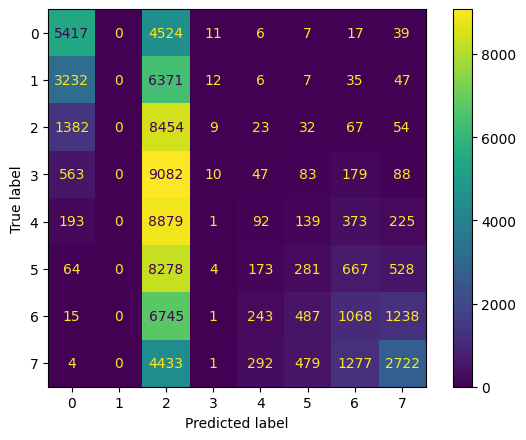

In [304]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Segunda ejecución con Grid Search

Se prueba ahora a hacer Random Search sobre Decission Tree Classifier

In [311]:
decissionTree = tree.DecisionTreeClassifier(random_state=8)
parameters = {'criterion':('gini', 'entropy'), 'splitter':('best', 'random'), 'max_depth':[20,40,60,80,100], 'max_features':['auto','sqrt'],'min_samples_leaf':[1,2,4],
              'min_samples_split':[2,5,10]}
decissionTree_RS = RandomizedSearchCV(decissionTree, parameters, random_state = 8, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
decissionTree_RS = decissionTree_RS.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [312]:
decissionTree_RS.best_params_

{'splitter': 'best',
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'gini'}

### Random Forest RS

In [313]:
randomForest = RandomForestClassifier(random_state=8, n_estimators=2000, min_samples_split=2, min_samples_leaf=4,
                                            max_features='sqrt', max_depth=100, criterion='gini', bootstrap=True)
randomForest = randomForest.fit(X_train, y_train)
randomForest.score(X_test, y_test)

0.309480852793942

In [314]:
predict = randomForest.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
14154,8,8
132293,1,3
39131,1,1
346831,3,4
159232,8,4
...,...,...
198324,7,6
155383,7,8
369829,3,5
238184,7,5


In [315]:
mean_absolute_error(y_test, predict)

1.1802276827687852

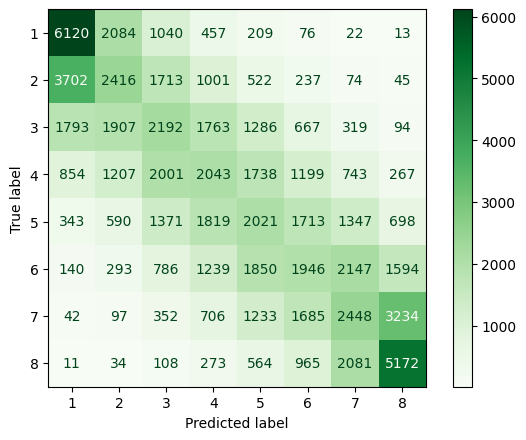

In [316]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=randomForest.classes_)
disp.plot(cmap='Greens')
plt.show()

### Decission Tree RS

In [317]:
decissionTree = tree.DecisionTreeClassifier(random_state=8, splitter='best', min_samples_split=2, min_samples_leaf=4,
 max_features='sqrt', max_depth=40, criterion='gini')
decissionTree = decissionTree.fit(X_train, y_train)
decissionTree.score(X_test, y_test)

0.27658628312962164

In [318]:
predict = decissionTree.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
14154,6,8
132293,4,3
39131,2,1
346831,3,4
159232,8,4
...,...,...
198324,7,6
155383,7,8
369829,2,5
238184,6,5


Para comprobar la calidad del algoritmo se puede mirar el valor del MAE, que da el error medio entre los datos predichos y los esperados

In [319]:
mean_absolute_error(y_test, predict)

1.322249892003151

Se genera también la matriz de confusión para comprobar los resultados de forma más exhaustiva

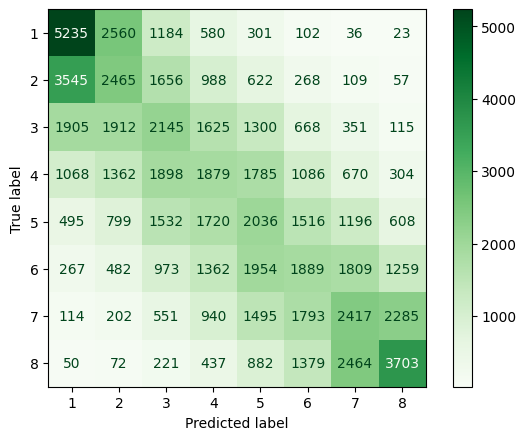

In [320]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=decissionTree.classes_)
disp.plot(cmap='Greens')
plt.show()

### Logistic Regression RS

In [351]:
regression = LogisticRegression(random_state=8, n_jobs=8, C=21.839648844407012, penalty='l2', solver='newton-cg')
regression = regression.fit(X_train, y_train)
regression.score(X_test, y_test)

0.3067618733006378

In [352]:
predict = regression.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
14154,8,8
132293,3,3
39131,1,1
346831,2,4
159232,8,4
...,...,...
198324,6,6
155383,8,8
369829,3,5
238184,7,5


In [353]:
mean_absolute_error(y_test, predict)

1.1932254211877111

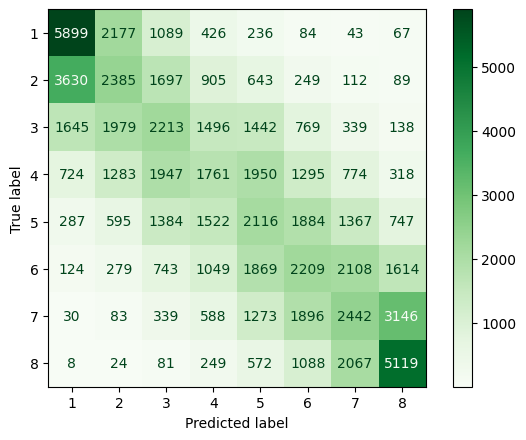

In [354]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regression.classes_)
disp.plot(cmap='Greens')
plt.show()

## Iteración con solo rank 1

In [358]:
third_data_frame = second_data_frame[second_data_frame['rank']==1]
third_data_frame

,level,position,rank,Blademaster,Blaster,Brawler,Celestial,Chrono,Cybernetic,Dark Star,...,champion5,champion6,champion7,champion8,champion9,champion10,champion11,champion12,teamCost,traitsValue
0,8,1,1,0,0,0,1,0,0,0,...,9.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,98,7
1,9,2,1,1,1,0,0,0,0,0,...,12.0,12.0,12.0,5.0,15.0,0.0,0.0,0.0,74,9
2,8,3,1,0,0,0,0,0,0,1,...,9.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,83,8
3,8,4,1,0,0,0,0,0,0,0,...,12.0,5.0,15.0,5.0,0.0,0.0,0.0,0.0,67,12
4,9,5,1,0,1,0,0,0,0,0,...,4.0,15.0,5.0,15.0,15.0,0.0,0.0,0.0,68,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78869,7,4,1,0,0,0,0,0,0,0,...,9.0,9.0,12.0,0.0,0.0,0.0,0.0,0.0,84,10
78870,8,5,1,1,0,0,0,1,3,0,...,9.0,12.0,15.0,15.0,0.0,0.0,0.0,0.0,63,7
78871,9,6,1,0,0,3,0,1,0,0,...,9.0,12.0,12.0,4.0,5.0,0.0,0.0,0.0,63,12
78872,8,7,1,0,3,3,0,1,0,0,...,9.0,12.0,12.0,5.0,0.0,0.0,0.0,0.0,53,7


In [359]:
y = third_data_frame['position']
X = third_data_frame.drop(columns=['position'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
X_test

,level,rank,Blademaster,Blaster,Brawler,Celestial,Chrono,Cybernetic,Dark Star,Demolitionist,...,champion5,champion6,champion7,champion8,champion9,champion10,champion11,champion12,teamCost,traitsValue
46209,8,1,0,0,0,0,0,0,0,0,...,27.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,77,6
8850,9,1,0,1,0,0,0,3,0,3,...,9.0,12.0,15.0,15.0,15.0,0.0,0.0,0.0,79,8
60119,7,1,0,0,0,0,0,0,0,0,...,27.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,87,6
48481,9,1,1,1,0,0,1,3,0,0,...,9.0,9.0,12.0,15.0,15.0,0.0,0.0,0.0,78,7
25903,8,1,0,1,3,1,1,0,0,0,...,9.0,12.0,12.0,5.0,0.0,0.0,0.0,0.0,60,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54169,8,1,0,0,0,0,0,3,0,0,...,9.0,9.0,12.0,5.0,0.0,0.0,0.0,0.0,56,5
47208,8,1,0,3,3,0,1,0,0,0,...,9.0,12.0,12.0,15.0,0.0,0.0,0.0,0.0,66,7
31305,9,1,0,3,3,1,1,0,0,0,...,9.0,12.0,12.0,5.0,5.0,0.0,0.0,0.0,67,8
58086,8,1,0,3,3,0,1,0,0,0,...,9.0,12.0,12.0,5.0,0.0,0.0,0.0,0.0,59,7


In [372]:
decissionTree = tree.DecisionTreeClassifier(random_state=8)
parameters = {'criterion':('gini', 'entropy'), 'splitter':('best', 'random'), 'max_depth':[20,40,60,80,100], 'max_features':['auto','sqrt'],'min_samples_leaf':[1,2,4],
              'min_samples_split':[2,5,10]}
decissionTree_RS = RandomizedSearchCV(decissionTree, parameters, random_state = 8, n_iter = 100, cv = 3, verbose=2, n_jobs = -1)
decissionTree_RS = decissionTree_RS.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [373]:
decissionTree_RS.best_params_

{'splitter': 'best',
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'entropy'}

### Random Forest RS

In [360]:
randomForest = RandomForestClassifier(random_state=8, n_estimators=2000, min_samples_split=2, min_samples_leaf=4,
                                            max_features='sqrt', max_depth=100, criterion='gini', bootstrap=True)
randomForest = randomForest.fit(X_train, y_train)
randomForest.score(X_test, y_test)

0.31391442155309035

In [361]:
predict = randomForest.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
46209,5,4
8850,1,2
60119,3,1
48481,2,1
25903,5,4
...,...,...
54169,7,4
47208,7,6
31305,3,3
58086,5,5


In [362]:
mean_absolute_error(y_test, predict)

1.186434231378764

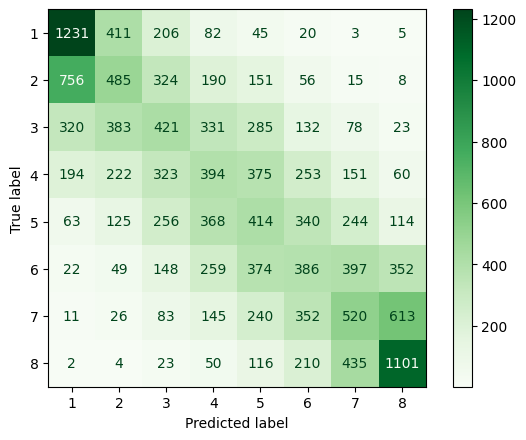

In [363]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=randomForest.classes_)
disp.plot(cmap='Greens')
plt.show()

### Decission Tree RS

In [374]:
decissionTree = tree.DecisionTreeClassifier(random_state=8, splitter='best', min_samples_split=2, min_samples_leaf=4,
 max_features='sqrt', max_depth=40, criterion='gini')
decissionTree = decissionTree.fit(X_train, y_train)
decissionTree.score(X_test, y_test)

0.2715689381933439

In [365]:
predict = decissionTree.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
46209,5,4
8850,3,2
60119,7,1
48481,2,1
25903,3,4
...,...,...
54169,7,4
47208,5,6
31305,4,3
58086,4,5


In [366]:
mean_absolute_error(y_test, predict)

1.3392076069730587

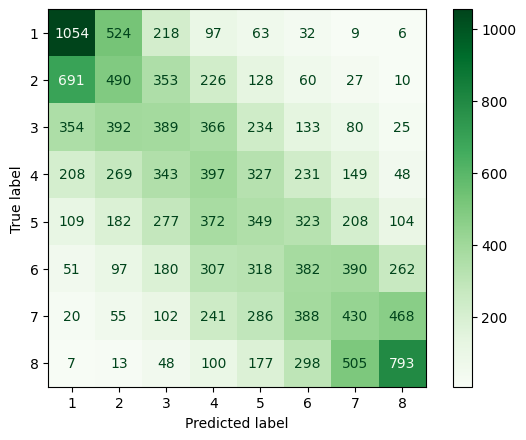

In [367]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=decissionTree.classes_)
disp.plot(cmap='Greens')
plt.show()

### Logistic Regression RS

In [368]:
regression = LogisticRegression(random_state=8, n_jobs=8, C=21.839648844407012, penalty='l2', solver='newton-cg')
regression = regression.fit(X_train, y_train)
regression.score(X_test, y_test)

0.3197464342313788

In [369]:
predict = regression.predict(X_test)
pd.DataFrame({'predicted': predict, 'expected': y_test})

,predicted,expected
46209,4,4
8850,1,2
60119,5,1
48481,2,1
25903,4,4
...,...,...
54169,6,4
47208,5,6
31305,3,3
58086,5,5


In [370]:
mean_absolute_error(y_test, predict)

1.1456101426307448

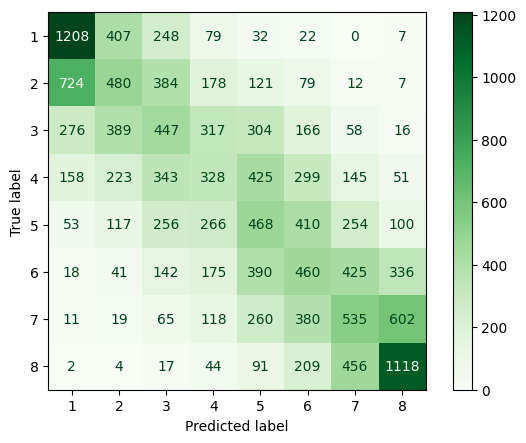

In [371]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=regression.classes_)
disp.plot(cmap='Greens')
plt.show()